## Measuring rotation in Psc-Eri

In [1]:
from astroquery.vizier import Vizier
from astropy import units as u
from astropy.coordinates import Angle
import numpy as np
import pandas as pd

cat = Vizier(catalog ='J/AJ/158/77/table2',
       columns = ['Source', 'RA_ICRS', 'DE_ICRS', 'GBP-GRP', 'Teff', 'Gmag','GMag', 'Prot'])
cat.ROW_LIMIT = -1
df = cat.get_catalogs(cat.catalog)[0].to_pandas()

N = len(df)
df['ra'] = np.zeros(N)
df['dec'] = np.zeros(N)
for idx in range(N):
    psceri = df.loc[idx]
    source = psceri['Source']

    ra_str = psceri['RA_ICRS'].split(' ')
    units_ra = ['h','m','s']
    rep = ''.join([ra_str[i]+units_ra[i] for i in range(3)])
    ra = Angle(rep).to(u.deg)

    dec_str = psceri['DE_ICRS'].split(' ')
    units_dec = ['d','m','s']
    rep = ''.join([dec_str[i]+units_dec[i] for i in range(3)])
    dec = Angle(rep).to(u.deg)
    
    df.loc[idx, 'ra'] = ra.value
    df.loc[idx, 'dec'] = dec.value

In [6]:
df.loc[df.Source == 4984094970441940864]

,Source,RA_ICRS,DE_ICRS,GBP-GRP,Teff,Gmag,GMag,Prot,ra,dec
100,4984094970441940864,01 21 49.7,-42 01 22.3,1.852,4113,12.731,8.099,5.45,20.457083,-42.022861


[Curtis et al. (2019)](https://arxiv.org/pdf/1905.10588.pdf) measured rotation for the Meingast et al. (2019) members o the Psc-Eri stellar stream, and found a clear co-eval structure in rotation-colour space.

Here, we will attempt to recover that same co-eval structure in the 101 stars targeted in that study, using `michael` only.

In [2]:
import sys
sys.path.insert(0, "../")

from michael import janet
import numpy as np
import lightkurve as lk
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from jax import random
rng = random.PRNGKey(53)

from astroquery.vizier import Vizier
from astropy.coordinates import Angle
from astropy import units as u

import warnings
warnings.filterwarnings('ignore')

Hi there. Welcome to the good place.


In [3]:
cat = Vizier(catalog ='J/AJ/158/77/table2',
       columns = ['Source', 'RA_ICRS', 'DE_ICRS', 'GBP-GRP', 'Teff', 'Gmag','GMag', 'Prot'])
cat.ROW_LIMIT = -1
df = cat.get_catalogs(cat.catalog)[0].to_pandas()

N = len(df)
df['ra'] = np.zeros(N)
df['dec'] = np.zeros(N)

Already have data downloaded for Gaia ID 5181474045115843072.
If you want to check for new data, run `janet.update()`.
### Running Simple Astropy Lomb-Scargle on Sector 4 on star 5181474045115843072 ###
### Completed Simple Astropy Lomb-Scargle for Sector 4 on star 5181474045115843072 ###
### Running Wavelet Estimation for Sector 4 on star 5181474045115843072 ###


  0%|          | 0/258 [00:00<?, ?it/s]

### Completed Wavelet Estimation for Sector 4 on star 5181474045115843072 ###
### Running Composite ACF estimation for Sector 4 on star 5181474045115843072 ###
### Completed Composite ACF estimation for Sector 4 on star 5181474045115843072 ###
### Running ACF Estimation on star 5181474045115843072 ###
### Completed ACF Estimation for Sector 4 on star 5181474045115843072 ###
### Running Simple Astropy Lomb-Scargle on Sector 31 on star 5181474045115843072 ###
### Completed Simple Astropy Lomb-Scargle for Sector 31 on star 5181474045115843072 ###
### Running Wavelet Estimation for Sector 31 on star 5181474045115843072 ###


  0%|          | 0/253 [00:00<?, ?it/s]

### Completed Wavelet Estimation for Sector 31 on star 5181474045115843072 ###
### Running Composite ACF estimation for Sector 31 on star 5181474045115843072 ###
### Completed Composite ACF estimation for Sector 31 on star 5181474045115843072 ###
### Running ACF Estimation on star 5181474045115843072 ###
### Completed ACF Estimation for Sector 31 on star 5181474045115843072 ###



------ Decoding Overall Period Flag 0 ------

No other flags raised. 



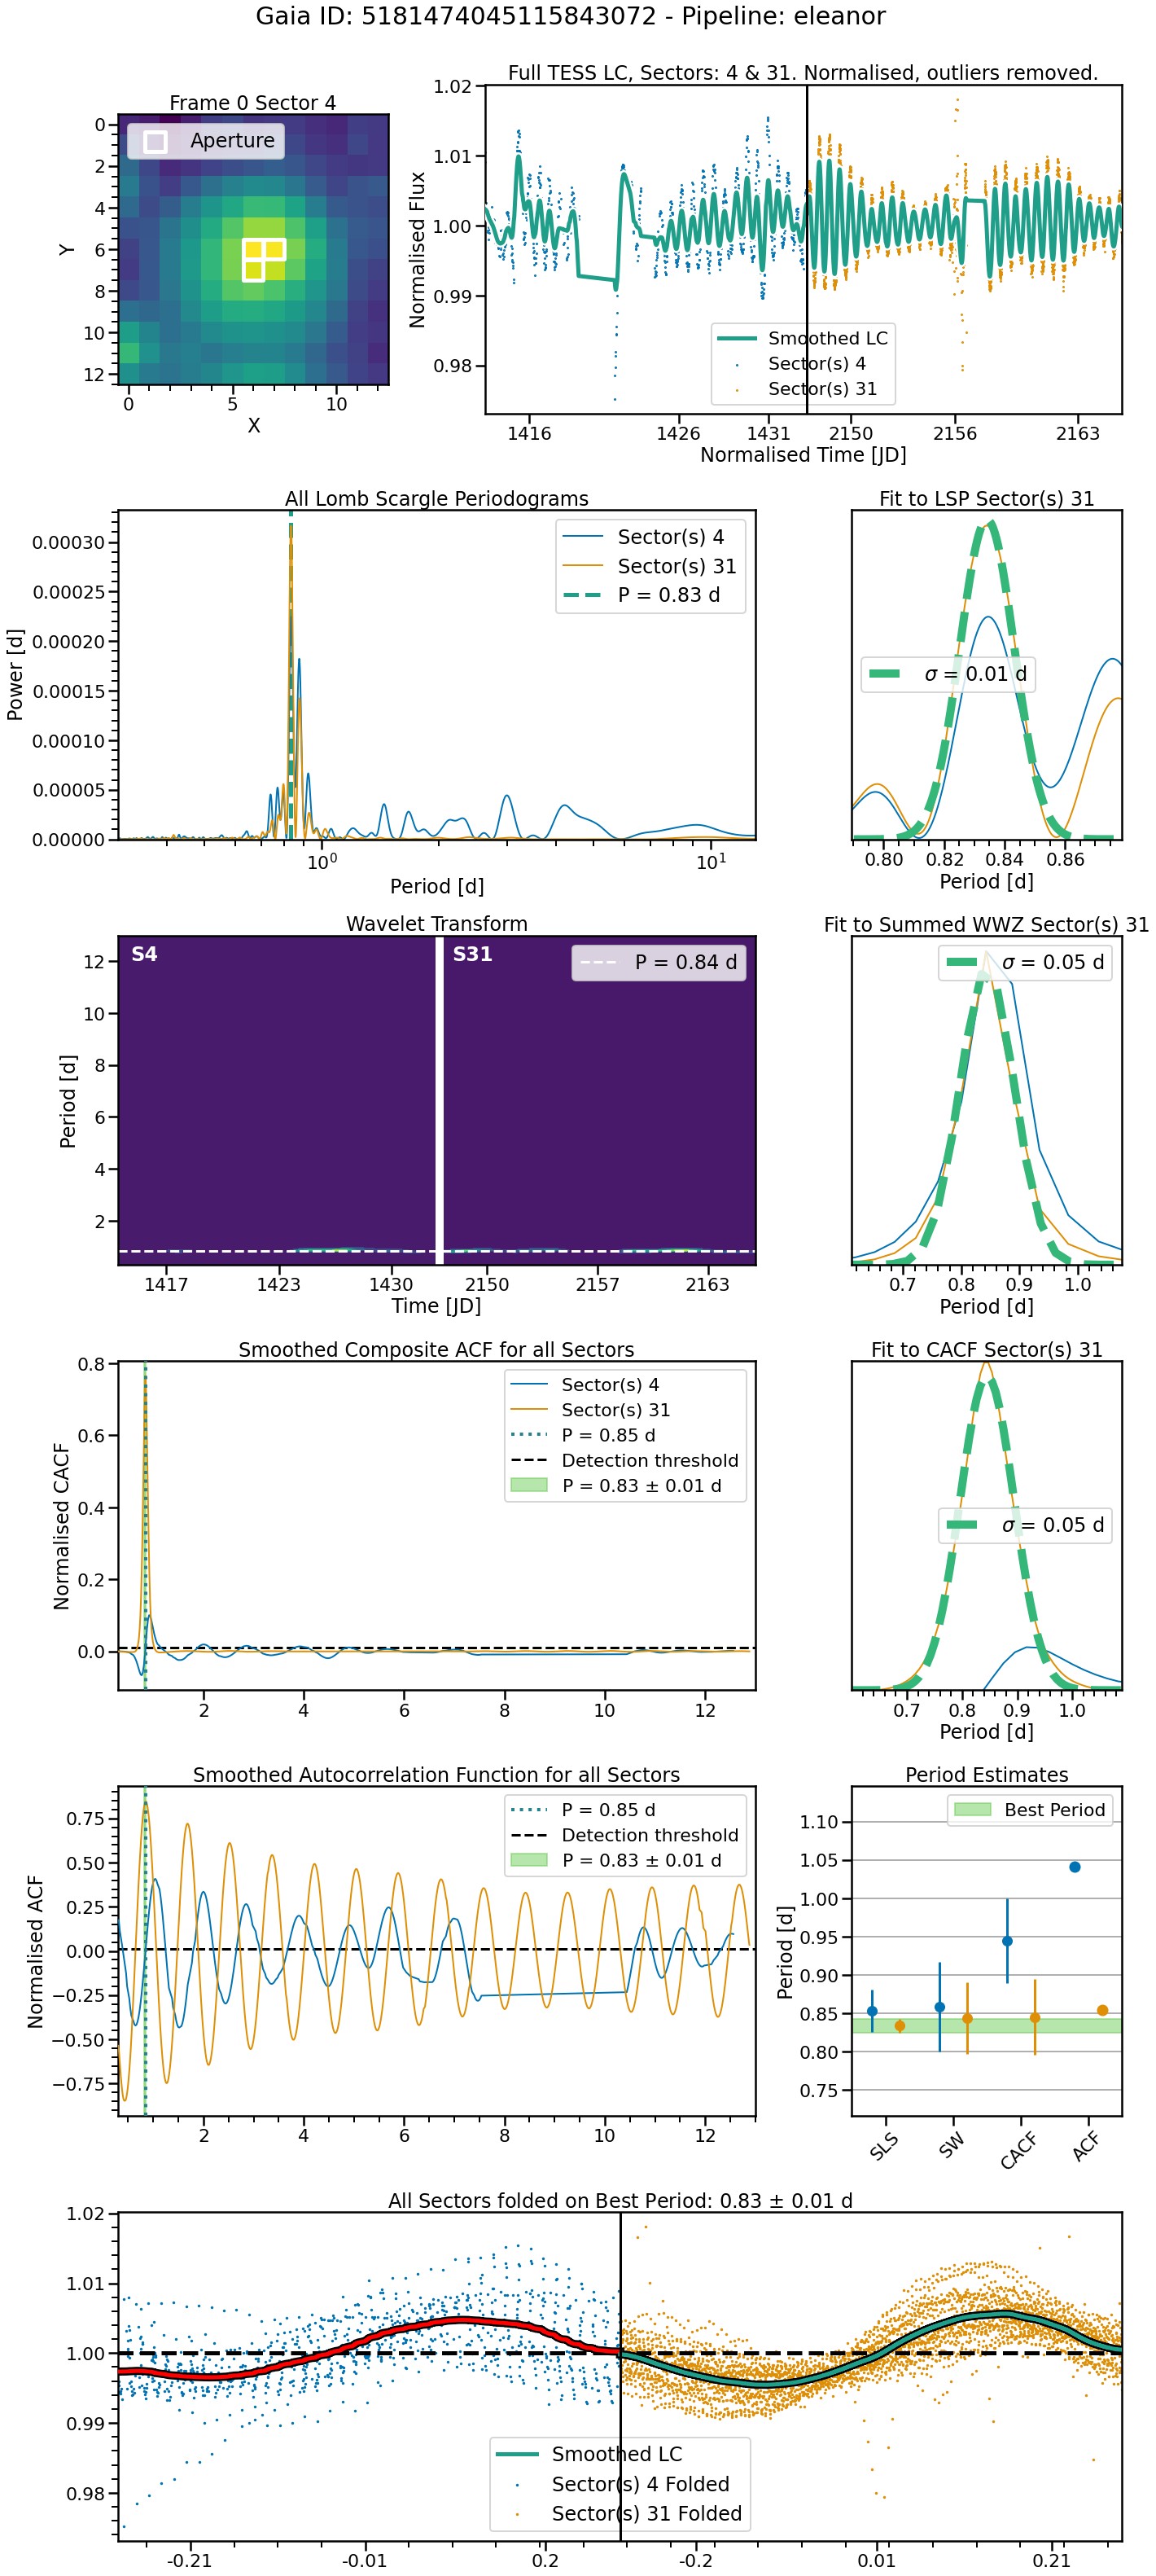

In [10]:
idx=1
psceri = df.loc[idx] 
source = psceri['Source']

ra_str = psceri['RA_ICRS'].split(' ')
units_ra = ['h','m','s']
rep = ''.join([ra_str[i]+units_ra[i] for i in range(3)])
ra = Angle(rep).to(u.deg)

dec_str = psceri['DE_ICRS'].split(' ')
units_dec = ['d','m','s']
rep = ''.join([dec_str[i]+units_dec[i] for i in range(3)])
dec = Angle(rep).to(u.deg)

j = janet(source, ra, dec,
      output_path = "/Users/oliver hall/Research/michael/Examples/PscEri",
      verbose = True,
      pipeline = 'eleanor')

j.run(period_range = (0.3, 13.))

In [14]:
j.results

,SLS,e_SLS,h_SLS,f_SLS,SW,e_SW,h_SW,CACF,e_CACF,h_CACF,...,f_p2p_ACF,s_SLS,s_SW,s_CACF,s_ACF,f_overall,overall,e_overall,method_overall,p2p_overall
4,0.853160,0.027512,0.000202,0.0,0.858461,0.058233,0.992842,0.944638,0.055280,0.104627,...,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
31,0.834209,0.008937,0.000322,0.0,0.844068,0.046430,0.946891,0.845336,0.048998,0.732134,...,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
best,0.834209,0.008937,0.000322,0.0,0.844068,0.046430,0.946891,0.845336,0.048998,0.732134,...,NaN,31,31,31,31,0,0.834209,0.008937,SLS,0.010185


In [11]:
lc.plot()

NameError: name 'lc' is not defined

In [ ]:
lc.plot()

In [ ]:
acf = np.correlate(lc.flux.value-1, lc.flux.value-1, mode='full')[len(lc)-1:]
plt.plot(acf)

In [ ]:
lc = j.void[f'clc_31']
flc = lc.fold(j.results.loc['31','SLS'])
flc.scatter()

In [ ]:
sys.exit()

In [ ]:
from tqdm import tqdm

N = len(psceri_full)

df = pd.DataFrame(index = range(N), columns=['P', 'Perr', 'Pflag'])

for idx in tqdm(range(N)):
    psceri = psceri_full[idx]
    source = psceri['Source']

    ra_str = psceri['RA_ICRS'].split(' ')
    units_ra = ['h','m','s']
    rep = ''.join([ra_str[i]+units_ra[i] for i in range(3)])
    ra = Angle(rep).to(u.deg)

    dec_str = psceri['DE_ICRS'].split(' ')
    units_dec = ['d','m','s']
    rep = ''.join([dec_str[i]+units_dec[i] for i in range(3)])
    dec = Angle(rep).to(u.deg)

    try:
        j = janet(source, ra, dec,
              output_path = "/Users/oliver hall/Research/michael/Examples/PscEri",
              verbose = True)
    
#         j.run(period_range = (psceri['Prot'].min()*0.5, 
#                               psceri['Prot'].max()*1.5))
        j.run(period_range = (0.3, 13.))
        
        plt.show()
        df.loc[idx, 'P']= j.results.loc['best', 'overall']
        df.loc[idx, 'Perr']= j.results.loc['best', 'e_overall']
        df.loc[idx, 'Pflag']= j.results.loc['best', 'f_overall']
        
    except OSError:
        print('OSError, data issue.')
        df.loc[idx, 'P']= np.nan
        df.loc[idx, 'Perr']= np.nan
        df.loc[idx, 'Pflag']= np.nan
        
    df['PC'] = np.array(psceri_full['Prot'].data)
    df.to_csv('PscEri/PscEri_periods.csv')

In [ ]:
df[0]

In [ ]:
df = pd.read_csv('PscEri/PscEri_periods.csv', index_col=0)
df

In [ ]:
cmap = sns.color_palette('colorblind', 8)

# s = df.Pflag <= 256

fig = plt.figure(figsize=(8,8))
plt.scatter(df.P, psceri_full['Prot'], s=100, c=cmap[1])
plt.errorbar(df.P, psceri_full['Prot'], xerr=df.Perr, fmt='|', zorder=0, c=cmap[1])

plt.scatter(out.P, outPE['Prot'], s=100, c=cmap[1], ec='k')

x = np.linspace(df.P.min(), df.P.max())
plt.plot(x, 2*x, ls=':', lw=4, c=cmap[0])
plt.plot(x, 0.5*x, ls=':', lw=4, c= cmap[0])
plt.plot(x, x, lw=4, c=cmap[2])

plt.xlabel('Michael Period [d]')
plt.ylabel('Curtis Period [d]')
plt.yscale('log')
plt.xscale('log')

In [ ]:
sns.set_context('poster')
cmap = sns.color_palette('colorblind', 8)
fig = plt.figure(figsize=(8,8))
plt.scatter(psceri_full['Teff'], df.P, zorder=3, s=40, c=cmap[0], ec='k',
           label = 'This work')
plt.scatter(psceri_full['Teff'], psceri_full['Prot'], zorder=2, ec='w', c=cmap[1],
           label = 'Curtis+19')
for idx in range(len(df)):
    plt.vlines(psceri_full[idx]['Teff'], 
                ymin = np.min([df.loc[idx, 'P'], psceri_full[idx]['Prot']]),
                ymax = np.max([df.loc[idx, 'P'], psceri_full[idx]['Prot']]),
                color= 'k', zorder=1)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'$T_{\rm eff}$ [$K$] (Curtis+19)')
plt.ylabel(r'$P_{\rm rot}$ [$d$]')
plt.grid(zorder=0)
plt.savefig('/Users/oliver hall/Desktop/fig4.png', dpi=300)


In [ ]:
sns.set_context('poster')
cmap = sns.color_palette('colorblind', 8)
fig = plt.figure(figsize=(8,8))

s = df.Pflag < 64
out = df[s]
outPE = psceri_full[s.values]


plt.scatter(outPE['Teff'], out.P, zorder=4, s=40, c=cmap[0], ec='k',
           label = 'This work')
plt.scatter(outPE['Teff'], outPE['Prot'], zorder=3, ec='w', c=cmap[1],
           label = 'Curtis+19')

for i, idx in enumerate(out.index):
    plt.vlines(outPE[i]['Teff'], 
                ymin = np.min([out.loc[idx, 'P'], outPE[i]['Prot']]),
                ymax = np.max([out.loc[idx, 'P'], outPE[i]['Prot']]),
                color= 'k', zorder=1)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'$T_{\rm eff}$ [$K$] (Curtis+19)')
plt.ylabel(r'$P_{\rm rot}$ [$d$]')
plt.grid(zorder=0)
plt.savefig('/Users/oliver hall/Desktop/fig4.png', dpi=300)


## Let's investigate outliers

We're focusing on targets that are more than $2\sigma$ outside the PscEri value

In [ ]:
s = np.abs(df.P.values - psceri_full['Prot']) > 2*df.Perr.values
out = df[s]
outPE = psceri_full[s]

fig = plt.figure(figsize=(8,8))
plt.scatter(out.P, outPE['Prot'], s=100, c=cmap[1])
plt.errorbar(out.P, outPE['Prot'], xerr=out.Perr, fmt='|', zorder=0, c=cmap[1])

x = np.linspace(out.P.min(), out.P.max())
plt.plot(x, 2*x, ls=':', lw=4, c=cmap[0])
plt.plot(x, 0.5*x, ls=':', lw=4, c= cmap[0])
plt.plot(x, x, lw=4, c=cmap[2])

plt.xlabel('Michael Period [d]')
plt.ylabel('Curtis Period [d]')
plt.yscale('log')
plt.xscale('log')

In [ ]:
len(out)/101

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.scatter(outPE['Teff'], out.P, zorder=4, s=40, c=cmap[0], ec='k',
           label = 'This work')
plt.scatter(outPE['Teff'], outPE['Prot'], zorder=3, ec='w', c=cmap[1],
           label = 'Curtis+19')
plt.errorbar(outPE['Teff'], out.P, yerr=out.Perr, fmt='o', barsabove=True, 
             elinewidth=4, zorder=2)
for i, idx in enumerate(out.index):
    plt.vlines(outPE[i]['Teff'], 
                ymin = np.min([out.loc[idx, 'P'], outPE[i]['Prot']]),
                ymax = np.max([out.loc[idx, 'P'], outPE[i]['Prot']]),
                color= 'k', zorder=1)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'$T_{\rm eff}$ [$K$] (Curtis+19)')
plt.ylabel(r'$P_{\rm rot}$ [$d$]')
plt.grid(zorder=0)

## Other plots

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.scatter(psceri_full[s]['Teff'], df[s]['P'], zorder=3, s=40, c=cmap[0], ec='k',
           label = 'This work')
plt.errorbar(psceri_full[s]['Teff'], df[s]['P'], zorder=0, fmt='|',
           yerr = df[s]['Perr'])
plt.gca().invert_xaxis()

Which stars do ont fall within 1 sigma of the curtis targets?

In [ ]:
s = np.abs(df.P.values - psceri_full['Prot']) < 2*df.Perr.values
dfs = df[~s].reset_index()

In [ ]:
sns.set_context('poster')
cmap = sns.color_palette('colorblind', 8)
fig = plt.figure(figsize=(8,8))
plt.scatter(psceri_full[~s]['Teff'], dfs.P, zorder=4, s=40, c=cmap[0], ec='k',
           label = 'This work')
plt.scatter(psceri_full[~s]['Teff'], psceri_full[~s]['Prot'], zorder=3, ec='w', c=cmap[1],
           label = 'Curtis+19')
plt.errorbar(psceri_full[~s]['Teff'], dfs.P, yerr=dfs.Perr, fmt='o', barsabove=True, 
             elinewidth=4, zorder=2)
for idx in range(len(df[~s])):
    plt.vlines(psceri_full[~s][idx]['Teff'], 
                ymin = np.min([dfs.loc[idx, 'P'], psceri_full[~s][idx]['Prot']]),
                ymax = np.max([dfs.loc[idx, 'P'], psceri_full[~s][idx]['Prot']]),
                color= 'k', zorder=1)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'$T_{\rm eff}$ [$K$] (Curtis+19)')
plt.ylabel(r'$P_{\rm rot}$ [$d$]')
plt.grid(zorder=0)


In [ ]:
len(dfs)

In [ ]:
dfs

In [ ]:
psceri_full[~s].to_pandas().to_csv('psceri_disagreement.csv')

In [ ]:
psceri_full[~s].to_pandas()

In [ ]:
dfs['source_id'] = psceri_full[~s]['Source']
dfs

In [ ]:
df['source_id'] = psceri_full['Source']
df

In [ ]:
df.to_csv('psceri_michael_periods.csv')